<font size=6>

<b>Análisis de Datos con Python</b>
</font>

<font size=4>
    
Julio de 2025 <br/>

</font>

https://github.com/michaelsanchez2025/inspirastem2025-data-analisis

<br/>

# Fundamentos de Pandas

## Objetivos

- La librería de manipulación de datos Pandas.

- Estructuras de datos fundamentales de Pandas: Series (unidimensionales) y DataFrames (bidimensionales).

- Funciones de la librería para entrada y salida.

- Tipos de datos en pandas. Tipos categóricos.

- Operaciones de indexado y selección de datos.

- Operaciones vectoriales (sin bucles explícitos).

## Introducción

Pandas ofrece estructuras de datos flexibles y eficientes diseñadas para trabajar de manera intuitiva con datos relacionales o etiquetados. Se ha convertido en una pieza fundamental para el análisis de datos (para transformación, limpieza, filtrado, selección) en Python.

Pandas presume de trabajar bien con:

- Datos tabulados con tipos heterogéneos (procedentes de tablas SQL u hojas Excel)
- Series temporales ordenadas o desordenadas.
- Matrices de datos con datos de tipo homogéneos o heterogéneos.
- En general, casi cualquier conjunto de datos observacional o estadístico.

Pandas se ha construido sobre NumPy y se integra bien con muchas otras librerías (p.ej. `seaborn` o `statsmodel`).

## Series y _DataFrames_
Las estructuras de datos fundamentales en Pandas son las `Series` y los `DataFrames`.

In [38]:
import os
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [7]:
from pathlib import Path

des = Path.cwd()
print(des)

/content


In [20]:
import shutil

# Replace 'repo-folder-name' with the name of the folder you want to delete
shutil.rmtree('/content/data-analysis-taller')
#https://github.com/mas940/data-analys-taller/
!git clone https://github.com/mas940/data-analysis-taller/

Cloning into 'data-analysis-taller'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 181 (delta 81), reused 42 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (181/181), 2.45 MiB | 7.11 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [21]:
!python data-analysis-taller/data/fits_read.py

In [27]:
import os

import numpy as np
from astropy.io import fits
from pathlib import Path


def fits_headers_to_dict(header):
    header_dict = {}
    for key, value in header.items():
        if key in header_dict.keys():
            header_dict[key] += " | " + value
        else:
            header_dict[key] = value
    return header_dict


def get_fits(path):
    hdul = fits.open(path)
    return hdul


def hdu_table_to_struct_array(hdu):
    dtype_list = hdu.data.dtype.descr
    return np.array(hdu.data, dtype=dtype_list)


class SpexodFITS:
    dynamic_types = {'hitran', 'fluxcal', 'lineflux', 'stackedline'}

    def __init__(self, path):
        # settings for a single instance
        self.path = path
        # static data types
        self.hdul = get_fits(path)
        self.header = self.get_header()
        self.header_dict = fits_headers_to_dict(self.header)
        self.wavelength_um, self.flux, self.flux_error = self.get_spectrum()
        self.header_observation = self.get_header_observation()
        self.header_observation_dict = fits_headers_to_dict(self.header_observation)
        # Dynamically added data types
        # Table data is converted to a is stored as numpy structured array
        # https://numpy.org/doc/stable/user/basics.rec.html
        self.hitran_tables_by_molecule = None  # each dict key (molecule) has a value that is a numpy structured array
        self.fluxcal = None
        self.linefluxes_by_transition = None
        self.stackedlines_by_transition = None

        for dynamic_hdu in self.hdul[3:]:
            self.dynamic_hdu_parse(dynamic_hdu=dynamic_hdu)

    def get_header(self):
        return self.hdul[0].header

    def get_spectrum(self):
        return self.hdul[1].data['wavelength_um'], self.hdul[1].data['flux'], self.hdul[1].data['flux_error']

    def get_header_observation(self):
        return self.hdul[2].header

    def dynamic_hdu_parse(self, dynamic_hdu):
        dynamic_type = dynamic_hdu.header["DYNMTYPE"].lower()
        if dynamic_type in self.dynamic_types:
            self.__getattribute__(f'set_{dynamic_type}')(dynamic_hdu)
        else:
            raise TypeError(f'Dynamic Type: {dynamic_type} is not one of the ' +
                            f'allowed dynamic types {self.dynamic_types}')

    def set_hitran(self, hitran_hdu):
        if self.hitran_tables_by_molecule is None:
            self.hitran_tables_by_molecule = {}
        molecule = hitran_hdu.header['MOLETYPE'].strip().upper()
        self.hitran_tables_by_molecule[molecule] = hdu_table_to_struct_array(hdu=hitran_hdu)

    def set_fluxcal(self, fluxcal_hdu):
        self.fluxcal = hdu_table_to_struct_array(hdu=fluxcal_hdu)

    def set_lineflux(self, lineflux_hdu):
        if self.linefluxes_by_transition is None:
            self.linefluxes_by_transition = {}
        transition = lineflux_hdu.header['FLXTRANS'].strip().replace(' ', '').upper()
        self.linefluxes_by_transition[transition] = hdu_table_to_struct_array(hdu=lineflux_hdu)

    def set_stackedline(self, stackedline_hdu):
        if self.stackedlines_by_transition is None:
            self.stackedlines_by_transition = {}
        transition = stackedline_hdu.header['STKTRANS'].strip().replace(' ', '').upper()
        self.stackedlines_by_transition[transition] = hdu_table_to_struct_array(hdu=stackedline_hdu)


if __name__ == "__main__":
    #star_dir = 'RULup'
    #file_name = 'crires_4645nm_4978nm_Vstar_RU_LUP.fits'
    #base_folder = '/data-analysis-taller/data/'#Path.cwd() # a fix for Google Colab specifically
    #data_folder = os.path.join(base_folder, 'data_products', '2022_07_24', star_dir)
    #abs_path = os.path.join(data_folder, file_name)
    example_data = SpexodFITS('data-analysis-taller/data/ishell_4517nm_5232nm_vstar_ru_lup.fits')


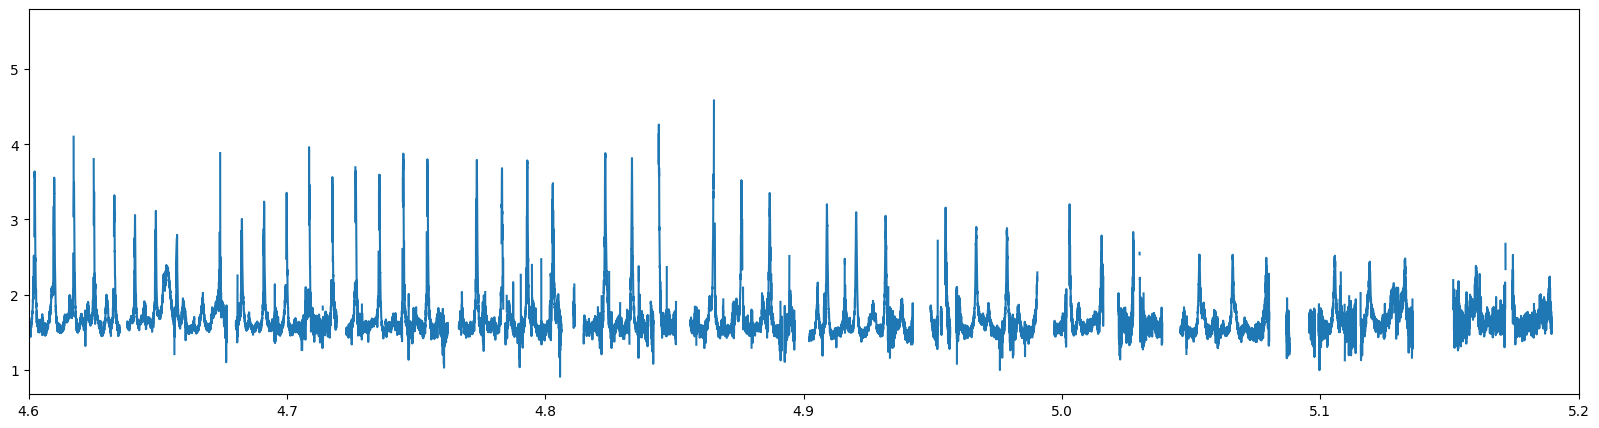

In [49]:
spectrum = (example_data.get_spectrum())
wv = example_data.wavelength_um
flux = example_data.flux
plt.figure(figsize=(20, 5))
plt.plot(wv, flux)
plt.xlim(4.6,5.2)
#plt.errorbar(wv, flux, yerr=example_data.flux_error, fmt='o-', capsize=4, label="Measurement")
plt.show()


### Series
Las Series son arrays unidimensionales de datos de cualquier tipo, etiquetados. El conjunto de etiquetas se denomina _índice_.

Las series se pueden construir a partir de por ejemplo un ndarray de NumPy, un diccionario/lista Python, o un valor escalar. Opcionalmente, se puede indicar un índice explícitamente (si no, se asignará uno de enteros crecientes desde 0).

In [ ]:
s1 = pd.Series([4, 9, 10])
s1

In [ ]:
s1 = pd.Series([4, 9, 10], index=('b', 'a', 'c'))
s1

In [ ]:
s1 = pd.Series({'b': 4, 'a': 9 , 'c': 10})
s1

<br/>

Las Series permiten acceder a los valores asociados a una etiqueta (valor del índice), o asignarles nuevos valores, con la misma notación que en un diccionario Python.

In [ ]:
s1['c']

In [ ]:
s1['a'] = 10
s1

<br/>

Podemos recuperar los valores de una Series (es decir, sin el índice) con el método `.array` (como `PandasArray`), o `.to_numpy` (como `ndarray`).

In [ ]:
s1.array

In [ ]:
s1.to_numpy()

Las Series, como los ndarrays, tienen un `dtype` asociado. Además, opcionalmente, pueden tener una propiedad `Name`, que las nombra.

In [ ]:
s2 = pd.Series([4, 9 , 10], name='precios')
print('name:', s2.name)
print('dtype:', s2.dtype)

In [ ]:
print(s2)

In [ ]:
s2 = pd.Series([1, 'a'])
s2

### DataFrames
Los DataFrames son estructuras bidimensionales con columnas de datos de cualquier tipo. Se pueden asimilar a una hoja de cálculo, o una tabla de una base de datos, o, simplemente, un diccionario de objetos tipo Series. Los DataFrames etiquetan los datos con el índice y con los identificadores de cada columna.

Los DataFrames son el objeto más usado de Pandas. La información de un objeto Series puede contenerse en un DataFrame de una sola columna.

Los DataFrames se pueden construir de muchas maneras, p. ej. a partir de un diccionario de Series (con `NaN` para las claves sin valor en la serie):

In [ ]:
s1 = pd.Series([0, 1, 2], index=('juan', 'pedro', 'maria'))
s2 = pd.Series([10, 20], index=('juan', 'maria'))
print(s1)
print()
print(s2)

In [ ]:
df = pd.DataFrame({'primera': s1, 'segunda': s2})
df

In [ ]:
df.dtypes

Se puede indicar el índice con `index`,  e incluso restringir los valores de las Series que se incorporan.

In [ ]:
df2 = pd.DataFrame({'primera': s1, 'segunda': s2}, index=['juan', 'pedro'])
df2

También se puede construir un DataFrame a partir de otro. En el siguiente ejemplo usamos además el argumento `columns`, análogo a `index` para la otra dimensión.

In [ ]:
df

In [ ]:
df2 = pd.DataFrame(df, index=['juan', 'pedro'], columns=('primera',))
df2

Otras formas de construcción son partiendo de un dict; o de una lista de dicts, listas, o ndarrays.

Cuando los objetos no especifican claves, se utilizan secuencias de enteros para índice/columnas (salvo que se usen explícitamente los argumentos `index` o `columns`).

In [ ]:
df = pd.DataFrame({'col1': [1, 3], 'col2': [3, 5]})
df

In [ ]:
df = pd.DataFrame({'col1': [1, 3], 'col2': [3, 5]}, index=['row1', 'row2'])
df

In [ ]:
df = pd.DataFrame({'col1': {'row1': 1, 'row2': 2}, 'col2': {'row1': 3, 'row3': 5}})
df

In [ ]:
df = pd.DataFrame([[1, 2], [3, 5]], columns=['col1', 'col2'])
df

In [ ]:
df = pd.DataFrame([{'col1': 1, 'col2': 2},  {'col1': 3, 'col3': 5}], index=['row1', 'row2'])
df

Los atributos `values`, `index` y `columns` permiten acceder respectivamente a un ndarray del contenido del DataFrame, a los objetos índice de las filas y de las columnas.

In [ ]:
print(type(df.values))
print(df.values)

In [ ]:
print(df.index)
print(df.columns)

In [ ]:
df.columns[2]

El atributo `shape` muestra las dimensiones del DataFrame

In [ ]:
df.shape

Podemos mostrar un DataFrame con `print`, o, más bonito, con el método de Jupyter `display`.

In [ ]:
print(df)
display(df)

Otros métodos que permiten inspeccionar los contenidos de un DataFrame: `head`, `tail`, `info`.

<br/>

<div style="background-color:powderblue;">

**EJERCICIO e5_1:**
    
Construir un DataFrame como el siguiente:

```
        | peras | manzanas | uvas |
-----------------------------------
 enero  |   10  |     4    |  5   |
febrero |   20  |     9    | 12   |
 marzo  |    7  |     3    |  6   |

```
<br/>    

## Entrada y salida

Pandas soporta lectura y escritura de datos desde/a multitud de formatos diferentes. Para ello, proporciona una serie de métodos `pd.read_<formato>` y `pd.to_<formato>`.

En su forma básica los métodos reciben el nombre de un fichero para leer/escribir como argumento. P. ej. para leer de un fichero de texto:

```python
df = pd.read_csv(fname)
df = ...
df.to_csv(fname)
```

Otros formatos soportados son `json`, `pickle`, `Excel` (usando `openpyxl`), `Apache parquet` (usando `pyarrow`), `HDF5` (usando `PyTables`), y bases de datos SQL (usando `SQLAlchemy`).

Todos los formatos soportados, así como la documentación de las funciones de I/O se encuentran en:

  https://pandas.pydata.org/docs/user_guide/io.html

### Ejemplo CSV y ficheros de texto

Los métodos con formato `csv` sirven para consumir o producir datos desde ficheros de texto plano.

El formato que espera por defecto es el de 1 línea por fila y columnas separadas por comas. Sin embargo, se puede modificar usando los númerosos parámetros de las dos funciones de I/O, entre ellos:

- `sep`: cadena que separa los valores. Puede ser una expresión regular.
- `delim_whitespace`: boolean para usar `\s+` (es decir, una serie de espacios, tabuladores o saltos de línea) como delimitador (no especificar `sep`).
- `header`: número de línea en el fichero de entrada de donde leer las etiquetas de las columnas. Por defecto es `0` (primera línea). Usar `None` para no leerlas del fichero.
- `names`: indicar explícitamente las etiquetas de las columnas.
- `index_col`: número de columna que identifica las etiquetas de índice (defecto es `None`: no leerlas del fichero)

In [ ]:
df2

In [ ]:
fname = '/tmp/df2.csv'
df2.to_csv(fname, sep='|')

In [ ]:
!cat /tmp/df2.csv

In [ ]:
df3 = pd.read_csv(fname, sep='|', index_col=0)
df3.head()

<div style="background-color:powderblue;">

**EJERCICIO e5_2:**
   
Construir un DataFrame a partir del fichero existente `data/data_sample.csv`. Observar el resultado. Repetir la operación utilizando los argumentos apropiados (`delim_whitespace`, `comment`, `skiprows`, `use_cols`, `parse_dates`) para obtener un resultado limpio que tenga un índice de tipo `DatetimeIndex`, y solo contenga columnas numéricas.

## Tipos de datos

Pandas usa los tipos de NumPy y algunos propios más.

Como hemos visto, los objetos Series tienen un  `dtype` como los arrays de NumPy. Si los datos que lo componen no son de tipo homogéneo, entonces el `dtype` de la serie será `object` (tipo genérico).

Los DataFrames tiene un `dtype` por columna (que es equivalente a una serie). Se pueden ver con el atributo `dtypes`.

In [ ]:
df = pd.DataFrame([[0, 1, 2], ['a', 10, 11]])
display(df)
df.dtypes

Al construir un DataFrame, el parámetro `dtype` se puede usar para forzar el tipo de las Series.

In [ ]:
df2 = pd.DataFrame([[0, 1], [10, 11]], dtype=float)
display(df2)
df2.dtypes

<br/>

O se puede modificar después con el método `astype`.

In [ ]:
df

In [ ]:
df[[1,2]] = df[[1,2]].astype(float)
df.dtypes

### Datos categóricos
El tipo de datos `category` de Pandas corresponda a las variables de datos categóricas en estadística. Estas variables solo pueden tomar un valor de un conjunto finito de posibilidades dado. Ejemplos pueden ser _género_, _nacionalidad_ o _clase social_.

Los diferentes valores de una variable categórica pueden admitir orden (según se definan esas categorías), pero no operaciones aritméticas.

Además de por alguna razón técnica, la utilidad de las variables categóricas es marcar a rutinas de más alto nivel (quizás de otras librerías) de la naturaleza de estas variables, para que puedan darles un tratamiento adecuado.

Se pueden crear Series o columnas de DataFrame categóricos de varias maneras. Por ejemplo, indicando explícitamente su `dtype`, o con `astype`.

In [ ]:
s = pd.Series(["a", "b", "c", "a"], dtype="category")
s

In [ ]:
df = pd.DataFrame({"A": ["a", "b"], "B": ["c", "a"]})
df

In [ ]:
df.dtypes

In [ ]:
df = df.astype("category")
df

In [ ]:
df.dtypes

In [ ]:
display(df['A'].dtype)
display(df['B'].dtype)

<br/>

También pueden producirse como resultado de alguna función de Pandas. Por ejemplo, la función `cut` que divide un conjunto de datos en una serie de _bins_ (histograma).

In [ ]:
df = pd.DataFrame({"val": np.random.randint(0, 100, 20)})
df.head()

In [ ]:
df['bins'] = pd.cut(df.val, range(0, 105, 10))
df.head(10)

In [ ]:
df.bins.dtype

<br/>

Finalmente, para un control total de las categorías (por ejemplo para incluir categorías que no aparecen en los datos), se puede usar un objeto `pd.Categorical` (o el tipo `pd.CategoricalDtype`).

In [ ]:
cats = list("abcx")
cats

In [ ]:
cat1 = pd.Categorical(list("abca"), categories=cats)
cat2 = pd.Categorical(list("bccd"), categories=cats)
display(cat1)
display(cat2)

In [ ]:
df = pd.DataFrame({"A": cat1, "B": cat2})
display(df)
df['A'].dtypes

In [ ]:
from pandas.api.types import CategoricalDtype

df = pd.DataFrame({"A": list("abca"), "B": list("bccd")})
df

In [ ]:
df.dtypes

In [ ]:
df['B'] = df['B'].astype(CategoricalDtype(categories=list("abc")))
display(df)
df.dtypes

In [ ]:
df['B'] = df['B'].astype(CategoricalDtype(categories=["pepe", "maria", "juan"]))
df

In [ ]:
df['B'].dtypes

<br/>

Las columnas o Series categóricas tienen atributos `cat.categories` y `cat.ordered`.

In [ ]:
s

In [ ]:
print('categories:', s.cat.categories)
print('orderd:', s.cat.ordered)

<br/>

En el método `read_csv`, visto anteriormente, se pueden capturar columnas categoricas directamente, especificando `dtype='category'`.

<div style="background-color:powderblue;">

**EJERCICIO e5_3:**
    
- Construir un DataFrame a partir del fichero `data/housing.csv`.

  - Ver su tamaño en memoria con `df.info`.


- Comprobar el valor medio en función de la cercanía al mar con la siguiente instrucción:
```python
df.groupby('ocean_proximity')['median_house_value'].mean()
```
<br/>

  - Medir la velocidad para la instrucción anterior con `%timeit -n 10`.


- A continuación, convertir la columna `ocean_proximity` a tipo categórico. Repetir los pasos anteriores y ver el impacto en memoria y tiempo de ejecución.

- Finalmente, refinar el tipo de `ocean_proximity` para que sean categorías ordenadas. El orden será el de la lista `newcats = ['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']`. Utilizar el método `cat.reorder_categories(newcats, ordered=True)` sobre la columna `ocean_proximity`.

  - Comprobar que ahora el resultado de la instrucción `groupby` anterior aparece ordenada de menor a mayor precio valor medio de las casas de cada categoría.

## Manipulación básica de datos

### Indexado y selección de datos

#### Series
Las Series ofrecen propiedades similares a los _ndarrays_ (selección, filtrado, soporte de operaciones vectoriales), y a los diccionarios (acceso a elementos por índice).

In [ ]:
s = pd.Series({'b': 4, 'a': 9 , 'c': 10})
display(s)

In [ ]:
print('\ns[0]')
print(s[0])

print('\ns[:2]')
print(s[:2])

print('\ns["a"]')
print(s["a"])

print('\ns.b')
print(s.b)

In [ ]:
s[s>9]

#### Selección básica de DataFrames

Los DataFrames ofrecen muchas posibilidades de selección (indexado).

Las básicas para columnas son:

- Selección de una columna con `df[colName]` o `df.colName`
- Selección de varias columnas con `df[[col1, col2...]]`

In [ ]:
df = pd.DataFrame([[0,1,2,3], [10,11,12,13], [20,21,22,23]],
            index=('r1', 'r2', 'r3'), columns=('c1', 'c2', 'c3', 'c4'))
df

In [ ]:
df.c1

<br/>

Podemos seleccionar varias columnas, pero, **importante**, debemos usar una lista, no una tupla.

In [ ]:
df[['c1', 'c3']]

Selección de filas con `df[slice]`, usando posición o etiquetas (en el caso de las etiquetas, los límites son *inclusivos*, mientras que para las posiciones solo el inicio).

In [ ]:
df['r1':'r2']

In [ ]:
df[1:2]

#### Selección de filas y columnas por etiquetas
Selección de filas y columnas por etiqueta, usando `df.loc`, usando un valor, una lista o un _slice_. Según la selección se devolverá un DataFrame, una Series, o un escalar.

In [ ]:
df.loc[['r1', 'r3'], 'c1':'c2']

In [ ]:
df.loc['r2', 'c3']

In [ ]:
df.loc[:, 'c2']

In [ ]:
df.loc['r2']

<br/>

#### Selección de filas y columnas por posición

Se usa el método `df.iloc`, que recibe argumentos como `df.loc`. Los siguientes ejemplos realizan las mismas selecciones vistas antes con `loc` usando ahora `iloc`.

In [ ]:
df.iloc[[0, 2], 1:3]

In [ ]:
df.iloc[1, 2]

In [ ]:
df.iloc[:, 1]

In [ ]:
df.iloc[1]

<br/>

#### Filtrado por máscaras.

Filtrando elementos de todo el Dataframe

In [ ]:
df

In [ ]:
df > 3

In [ ]:
df[df>3]

Filtrando filas

In [ ]:
row_mask = (df['c1']>3) & (df['c2']<20)
row_mask

In [ ]:
df[row_mask]

In [ ]:
df

Filtrando columnas

In [ ]:
col_mask = (df.loc['r1'] > 1) & (df.loc['r2'] < 20)   # df['c1'] , df.c1
col_mask

In [ ]:
df.loc[:, col_mask]

Filtrando filas y columnas

In [ ]:
df.loc[df['c1']>3, 'c1']

In [ ]:
# Otra manera de hacerlo (2 selecciones encadenadas)
df['c1'][df['c1']>3]

<br/>

#### Asignación parcial de valores
En general, las selecciones de datos también se pueden usar para asignar nuevos valores. Se recomienda usar `.loc`, con un solo indexado (veremos más detalles en el Tema 8).

In [ ]:
df.loc['r2':'r3', ['c1', 'c3']] = [[900, 901], [902, 903]]
df

In [ ]:
df.loc[df['c1']>3, 'c1'] = 999
df

<br/>
<div style="background-color:powderblue;">
    
**EJERCICIO e5_4:**
Dado el DataFrame `cursos`, intenta realizar las siguientes tares con `[]`, `.loc`, y `.iloc` (no siempre es posible).
- Extraer las series `Subject` y `Days`.
- Extraer los datos de los dos primeros curso (primeras filas).
- Mostrar los cursos que cuesten menos de 22000.

In [ ]:
cursos = {
    'Subject': ["Spark", "Pandas", "SQL"],
    'Fee':  [20000, 25000, 10000],
    'Days': [10, 15, 7]
}
cursos = pd.DataFrame(cursos)
cursos

### Operaciones vectoriales

#### Operaciones sobre un solo DataFrame
Los objetos DataFrame ofrecen operaciones que se aplican sobre sus elementos, y que internamente utilizan operaciones vectoriales NumPy, es decir que ofrecen mejor rendimiento que los bucles en código Python puro.

Algunos ejemplos simples:

In [ ]:
df = pd.DataFrame(np.arange(9).reshape(3,3), index=('r0', 'r1', 'r2'), columns=list('abc'))
df

In [ ]:
df.sum()         # Opera sobre cada una de las columnas

In [ ]:
df.sum(axis=1)   # Opera sobre cada una de las filas

<br/>

##### <u>apply<u/>
De manera genérica, se puede usar el método `df.apply` para aplicar una función sobre las columnas de un DataFrame (o las filas, usando `axis`). Se pueden distinguir dos casos:

- Agregación: se utiliza una función que reduzca una Series a un solo valor (se devuelve una Series con los valores agregados). En lugar de `apply`, también podemos usar `aggregate` (o `agg`).

- Transformación: la función modifica las Series y las devuelve, sin reducirlas. En lugar de `apply`, también podemos usar `transform`.


In [ ]:
df.apply(lambda x: 2*x)   # o df.transform
#
#
# Nota: lo anterior es equivalente a:
#
#   def myfunc(x): return 2*x
#   df.apply(myfunc)
#

In [ ]:
df.apply(np.max)    # o df.agg

In [ ]:
# También por filas
df.apply('max', axis='columns')

<br/>

Se pueden combinar operaciones de maneras más sofisticadas, p. ej.,  usar varias funciones de agregación (se crearán varias columnas para mostrar cada una), o aplicar diferentes funciones según la columna.

In [ ]:
df.apply(["sum", "mean"], axis=1)  # o df.agg

In [ ]:
funcs = {'a': lambda x: x+1, 'b': np.exp, 'c': np.abs}
df.apply(funcs)   # o df.transform

<br/>

##### <u>applymap<u/>
La función `map` (para Series) o `applymap` (para DataFrames) pueden usarse para operaciones que deben aplicarse elemento a elemento (en lugar de tomando como argumento filas o columnas enteras).

In [ ]:
def elemfunc(x):
    return f'val={x}'

df.applymap(elemfunc)

Además de lo dicho anteriormente, muchas de las funciones de NumPy que operan elemento a elemento se pueden aplicar directamente sobre DataFrames

In [ ]:
np.exp(df)

<br/>
<div style="background-color:powderblue;">
    
**EJERCICIO e5_5:**
Dado el DataFrame `cursos` del ejercicio `e5_4`, usa `apply` para crear una columna nueva `Accepted`, de tipo boolean, cuyo valor sea `'Yes'` si el curso cuesta menos de 22000, y `'No'` si cuesta más.

In [ ]:
cursos

#### Operaciones con más de un argumento
Las operaciones vectoriales entre dos Series son análogas a las vistas con ndarrays, con la diferencia de que con los arrays los elementos de los operandos se emparejan por su posición (se _alinean_), mientras que en las Series se alinean por el valor de su índice. Cuando un índice no tiene correspondencia para operar, el valor asociado es `NaN`.

In [ ]:
s1 = pd.Series({'pedro': 10, 'juan': 3})
s2 = pd.Series({'carmen': 8, 'pedro': 5})
display(s1)
print()
display(s2)

In [ ]:
s1 + s2

<br/>

Las operaciones entre dos DataFrames también se alinean, tanto en índice como en columnas, completando con `NaN` las posiciones que no coinciden.

In [ ]:
df1 = pd.DataFrame([[2, 2], [2, 2]], index=['r1', 'r2'], columns=['c1', 'c2'])
df2 = pd.DataFrame([[5, 5, 5], [4, 4, 4]], index=['r3', 'r1'], columns=['c1', 'c2', 'c3'])

In [ ]:
df1

In [ ]:
df2

In [ ]:
df1*df2

Sin embargo, si se usa un método de DataFrame (en lugar del operador con el signo matemático), normalmente se puede indicar un valor de relleno para reemplazar los `NaN` (salvo si ocurren en los dos operandos).

In [ ]:
df1.multiply(df2, fill_value=1)

En operaciones de un DataFrame con un escalar, Pandas realiza automáticamente un _broadcasting_ de los datos para extender el alcance a todo el DataFrame.

In [ ]:
display(df2)
df2 / 2

En el caso de operación de un DataFrame con una Series, el _broadcasting_ extiende la misma Series a cada una de las _filas_ del DataFrame, alineando el índice de la Series con las columnas del DataFrame.

In [ ]:
df2

In [ ]:
s = pd.Series([1, 10], index=['c1', 'c3'])
s

In [ ]:
df2 + s

También podemos operar contra las columnas, usando el parámetro `axis`.

In [ ]:
s = pd.Series([1, 10], index=['r1', 'r3'])
df2.add(s, axis='rows')

<div style="background-color:powderblue;">

**EJERCICIO e5_6:**
    
Cargar de nuevo los datos del fichero `data/housing.csv`.
    
Contar cuántas filas cumplen que el ratio de `total_rooms/households` es mayor de 8.
    
Seleccionar la primera mitad de las filas en el DataFrame, y, de ellas, las que cumplan la condición de ratio indicada. Crear un nuevo DataFrame que contenga solamente `longitude`, `latitude` y una nuevo columna con el ratio (`total_rooms/households`).